# 🧠 Day 11 – Image Classification with Transfer Learning

 📌 In this project, we aim to:
 - Use a pretrained CNN (like VGG16 or ResNet50) for image classification.
 - Learn how to freeze layers and fine-tune top layers.
 - Load image data using ImageDataGenerator.
 - Evaluate performance using accuracy, loss, and confusion matrix.
 ✅ We’ll use a subset of the Dogs vs Cats dataset.


In [20]:
# ✅ Step 1: Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
print("Current working directory:", os.getcwd())
print("Folders in current directory:")
print(os.listdir())

Current working directory: d:\Programming\Machine-Learning\Day 11
Folders in current directory:
['cats_and_dogs_filtered', 'Transfer Learning.ipynb']


In [22]:
# Correct base directory (based on confirmed structure)
base_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Confirm folder contents
print("✅ Train Cats:", os.listdir(os.path.join(train_dir, 'cats'))[:5])
print("✅ Train Dogs:", os.listdir(os.path.join(train_dir, 'dogs'))[:5])


✅ Train Cats: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
✅ Train Dogs: ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg']


In [23]:
# Image size and batch size
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Training data generator with rescaling (can augmentation here later)
train_datagen = ImageDataGenerator(rescale=1./255)

# Validation data generator just rescales
val_datagen = ImageDataGenerator(rescale=1./255)

# Create train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'   # because we have two classes (cats and dogs)
)

# Create validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model, excluding the top classification layer
base_model = VGG16(
    weights='imagenet',         # Use pretrained weights
    include_top=False,          # Do NOT include the dense layers at the top
    input_shape=(160, 160, 3)   # Input shape must match our resized images
)

# Freeze the entire base model so its weights don't change during training
base_model.trainable = False


In [25]:
# Get the output of the base model
x = base_model.output

# Flatten the 3D feature maps into 1D
x = Flatten()(x)

# Add a fully connected (dense) layer
x = Dense(256, activation='relu')(x)

# Add dropout for regularization (prevents overfitting)
x = Dropout(0.5)(x)

# Add the final output layer (binary classification: cat or dog)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [27]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


d:\Programming\Machine-Learning\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.6773 - loss: 0.5969 - val_accuracy: 0.8590 - val_loss: 0.3096
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 285s 5s/step - accuracy: 0.8863 - loss: 0.2749 - val_accuracy: 0.8870 - val_loss: 0.2695
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.9083 - loss: 0.2207 - val_accuracy: 0.8680 - val_loss: 0.2653
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.9356 - loss: 0.1699 - val_accuracy: 0.8720 - val_loss: 0.2614
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.9501 - loss: 0.1449 - val_accuracy: 0.8810 - val_loss: 0.2908


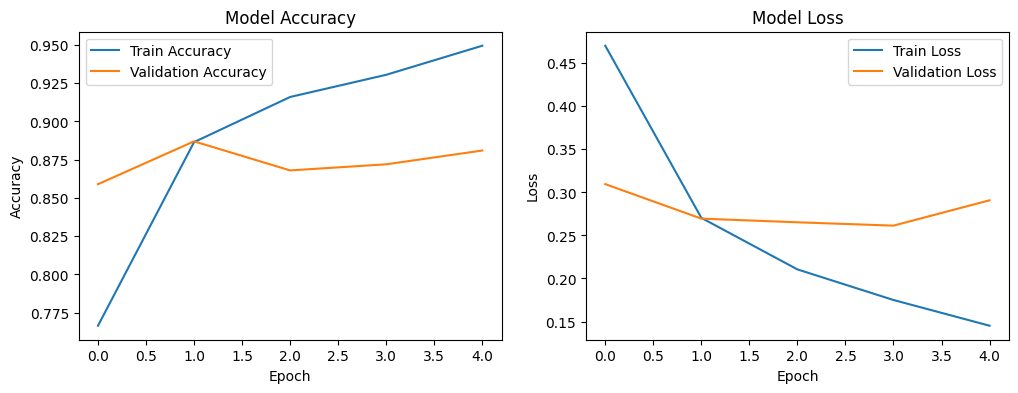

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [29]:
# Unfreeze some top layers of VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Keep all but last 4 layers frozen
    layer.trainable = False

# Recompile with low LR
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again
fine_tune_history = model.fit(train_generator, validation_data=val_generator, epochs=3)


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.9530 - loss: 0.1195 - val_accuracy: 0.9080 - val_loss: 0.2404
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.9845 - loss: 0.0621 - val_accuracy: 0.9030 - val_loss: 0.2317
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 328s 5s/step - accuracy: 0.9867 - loss: 0.0435 - val_accuracy: 0.9180 - val_loss: 0.2142


In [31]:
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {accuracy:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.9230 - loss: 0.2074
✅ Final Validation Accuracy: 0.9180


In [41]:
from tensorflow.keras.preprocessing import image

img_path = "test\\test6.jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0] > 0.5:
    print("🐶 It's a dog!")
else:
    print("🐱 It's a cat!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
🐶 It's a dog!


In [ ]:
# To save model if you are satisfied with the result
model.save("cats_vs_dogs_model.h5")

# To load the model afterwards
from tensorflow.keras.models import load_model
model = load_model("cats_vs_dogs_model.h5")
